# Tutorial 3: Fixed dimension MCMC with Eryn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the third tutorial, we are going to learn how to use MCMC through `Eryn` to do our data analysis investigations. In this tutorial, we will stick with simple examples and simple signals (like in Tutorial 1). In later tutorials, we will use eryn with real GW signals. 

## Task 1: build your own basic MCMC

In order to better understand MCMC and `Eryn`, we are going to start by building our own MCMC algorithm for a simple problem. We will do this with a single-dimensional Gaussian likelihood centered on ($\mu=0$) and a unit standard deviation ($\sigma=1$) and a uniform prior. 

In [2]:
def log_like_gauss(x):
    return -0.5 * x ** 2 - 1/2 * np.log(2 * np.pi * 1.0) # 1.0 is sigma

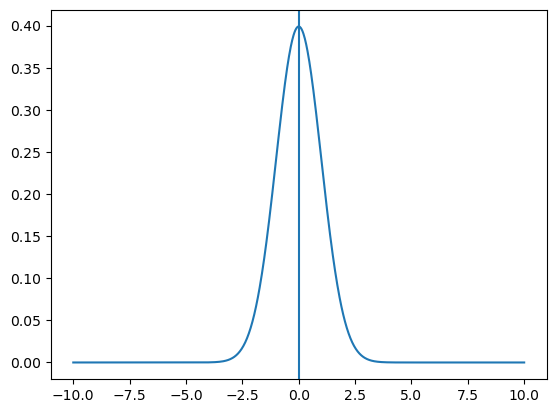

In [3]:
x_vals = np.linspace(-10.0, 10.0, 1000)
# notice the `exp` in there because we are working with the log of the likelihood.
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.axvline(0.0)

We are just going to write this into a simple loop. Gather your samples into the chain list.

In [4]:
num_steps = 100000

# get random starting point
current_point = np.random.uniform(-10.0, 10.0)
current_likelihood = log_like_gauss(current_point)
chain = []
for step in range(num_steps):
    # propose new point using a Gaussian distribution with standard deviation of 0.5
    # hint: use current + sigma * N() where N() is a draw from a normal distribution 
    # (np.random.randn)
    new_point = current_point + 0.5 * np.random.randn()

    # get new likelihood
    new_likelihood = log_like_gauss(new_point)

    # calculate the change in posterior
    # here we are using a uniform prior, so its value will not change, so for now do not
    # worry about the prior.
    delta_posterior = new_likelihood - current_likelihood  #  + (new_prior - old_prior)

    # accept or reject
    # if change in log posterior is greater than log(np.random.rand()), accept, else reject
    accept = delta_posterior > np.log(np.random.rand())

    if accept:
        current_point = new_point
        current_likelihood = new_likelihood

    chain.append(current_point)
    

Now plot the chain. You will notice that the beginnning requires a "burn in" phase. So, when calculating the posterior, you must remove this. There are ways to calculate how much burn in is appropriate, but we will not get into that here. 

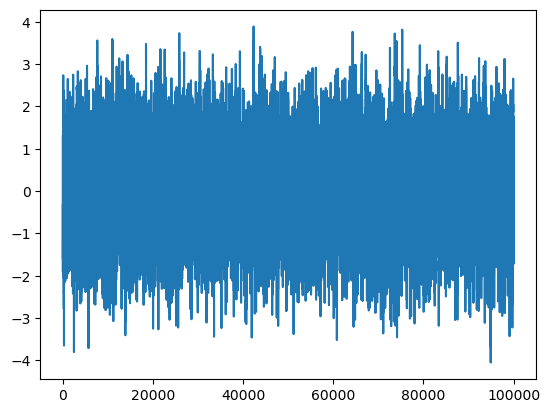

In [5]:
plt.plot(chain)

Plot the posterior distribution generated by the MCMC and compare it against the true Likelihood plot from above. Remember to set `density=True` when building the histogram.

If we take a step back here, we realize MCMC is really just a way to draw samples from a distribution. When the distribution is simple like this example, it will usually be available already with no need to run MCMC (like in scipy). However, in our area of work, the Likelihood distribution tends to be very difficult to deal with, which is why MCMC is so useful for us. To illustrate this, we will draw samples from the same distribution available in Numpy (`np.random.randn`).

(array([1.67954777e-04, 5.59849258e-05, 6.71819109e-04, 1.39962314e-03,
        3.41508047e-03, 8.39773887e-03, 1.03012263e-02, 1.81391160e-02,
        2.68167795e-02, 4.51238502e-02, 5.96799309e-02, 8.56009515e-02,
        1.24958354e-01, 1.65267501e-01, 2.06920286e-01, 2.50196633e-01,
        2.89721991e-01, 3.23424916e-01, 3.58695420e-01, 3.85008335e-01,
        3.88087506e-01, 3.80025676e-01, 3.62166485e-01, 3.28519545e-01,
        2.92129343e-01, 2.41966849e-01, 1.93427919e-01, 1.46344596e-01,
        1.12193791e-01, 7.93866248e-02, 5.37455288e-02, 4.05330863e-02,
        2.00985884e-02, 1.56197943e-02, 9.23751276e-03, 5.54250765e-03,
        2.35136688e-03, 1.90348748e-03, 1.06371359e-03, 3.35909555e-04]),
 array([-4.05071625, -3.85225013, -3.65378401, -3.45531789, -3.25685177,
        -3.05838564, -2.85991952, -2.6614534 , -2.46298728, -2.26452116,
        -2.06605503, -1.86758891, -1.66912279, -1.47065667, -1.27219055,
        -1.07372442, -0.8752583 , -0.67679218, -0.47832606,

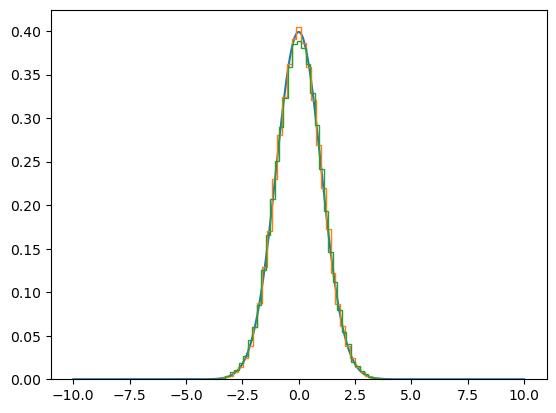

In [7]:
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))
plt.hist(np.random.randn(100000), bins=40, density=True, histtype="step")
plt.hist(chain[10000:], bins=40, density=True, histtype="step")

## Task 2: Use Eryn to reproduce the above result.

Now use the `EnsembleSampler` in `Eryn` to reproduce the above results. If you are struggling, look at the `Eryn` tutorial. For Eryn, you will need to define a prior. Use `uniform_dist` to create a simple uniform distribution. For this example, you only need to worry about the Ensemble Sampler keyword arguments. Leave those all as default values and only enter the arguments.

Useful documentation:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)

In [8]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

Initialize your sampler here. The prior initialization should take the form: `ProbDistContainer({0: prior distribution})`.

In [9]:
prior = ProbDistContainer({
    0: uniform_dist(-1000.0, 1000.0)
})
nwalkers = 20
ndim = 1 
sampler = EnsembleSampler(nwalkers, 1, log_like_gauss, prior)

Now choose your starting point (one for each walker). You can draw from the prior or not. Just make sure to remove any burn in at the end. Then put the starting point into a `State` object. The key here is the start point should have shape `(1, nwalkers, 1, ndim)`. Here the two 1s are for temperatures (which we are not using right now) and the number of leaves or model count (this is for RJ). After this is complete, run the sampler.

Documentation:
* [run_mcmc](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler.run_mcmc)

In [10]:
start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

In [11]:
end_point = sampler.run_mcmc(start_state, 100000)

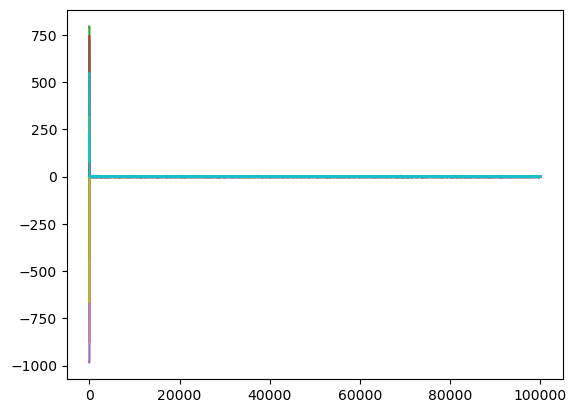

In [12]:
chain = sampler.get_chain()["model_0"]
for w in range(nwalkers):
    plt.plot(chain[:, 0, w, 0])

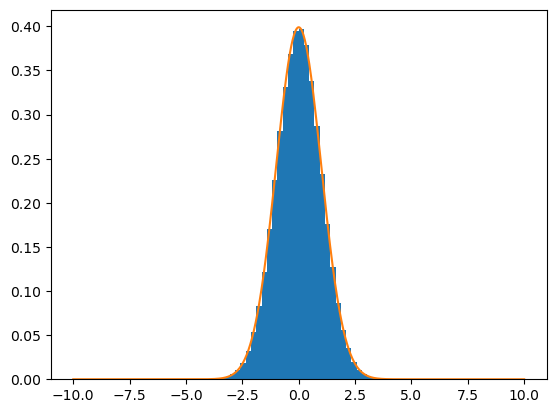

In [13]:
plt.hist(chain[10000:].flatten(), bins=40, density=True)
plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

## Task 3: Add GWs!

Now we will add GW signals in the form of the simple Sinusoid we used in the first tutorial. We will start with the waveform function. Set up the `DataResidualArray` (inject whatever parameter you would like), `SensitivityMatrix`, and `AnalysisContainer`. Remember, we do not have a response on this signal, so the sensitivity curve should be `LISASens`. 

In [14]:
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import SensitivityMatrix, LISASens

In [15]:
def sinusoidal_waveform(A: float, f0: float, fdot: float, phi0: float, t: np.ndarray, **kwargs) -> [np.ndarray, np.ndarray]:
    h1 = A * np.sin(2 * np.pi * (f0 * t + 1/2 * fdot * t ** 2) + phi0)
    h2 = A * np.cos(2 * np.pi * (f0 * t + 1/2 * fdot * t ** 2) + phi0)
    return [h1, h2]

In [16]:
dt = 10.0
t_arr = np.arange(100000) * dt
data = DataResidualArray(sinusoidal_waveform(1e-23, 2e-3, 1e-17, 0.0, t_arr), dt=dt)
sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens])
analysis = AnalysisContainer(data, sens_mat, signal_gen=sinusoidal_waveform)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools-0.0.1-py3.12-macosx-10.9-x86_64.egg/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools-0.0.1-py3.12-macosx-10.9-x86_64.egg/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools-0.0.1-py3.12-macosx-10.9-x86_64.egg/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/minic

In [17]:
analysis.calculate_signal_snr(1e-23, 2e-3, 1e-17, 0.0, t_arr)

(0.30849156386057164, 0.30849156386057164)

In [24]:
priors = ProbDistContainer({
    0: uniform_dist(9e-24, 3e-23),
    1: uniform_dist(1.5e-3, 2.5e-3),
    2: uniform_dist(1e-18, 1e-16),
    3: uniform_dist(0.0, 2 * np.pi)
})

ndim = 4
sampler = EnsembleSampler(
    nwalkers,
    ndim, 
    analysis.eryn_likelihood_function,
    priors,
    args=(t_arr,)
)

In [25]:
start_state = State(priors.rvs(size=(1, nwalkers, 1)))

In [26]:
sampler.run_mcmc(start_state, 1000, progress=True)

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  0%|                                          | 1/1000 [00:00<02:03,  8.11it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  0%|                                          | 2/1000 [00:00<02:07,  7.85it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  0%|▏                                         | 3/1000 [00:00<02:09,  7.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  0%|▏                                         | 4/1000 [00:00<02:15,  7.36it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  1%|▎                                         | 6/1000 [00:00<01:59,  8.32it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  1%|▎                                         | 7/1000 [00:00<01:54,  8.68it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  1%|▎                                         | 8/1000 [00:01<02:04,  7.95it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  1%|▍                                        | 10/1000 [00:01<01:53,  8.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  1%|▍                                        | 11/1000 [00:01<01:55,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  1%|▌                                        | 13/1000 [00:01<01:51,  8.89it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  2%|▌                                        | 15/1000 [00:01<01:57,  8.39it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  2%|▋                                        | 16/1000 [00:01<02:05,  7.83it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  2%|▋                                        | 18/1000 [00:02<02:03,  7.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  2%|▊                                        | 19/1000 [00:02<02:07,  7.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  2%|▊                                        | 20/1000 [00:02<02:33,  6.40it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  2%|▊                                        | 21/1000 [00:02<02:45,  5.92it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  2%|▉                                        | 22/1000 [00:02<02:35,  6.30it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  2%|▉                                        | 24/1000 [00:03<02:17,  7.11it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  3%|█                                        | 26/1000 [00:03<02:06,  7.71it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  3%|█▏                                       | 28/1000 [00:03<01:54,  8.47it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  3%|█▏                                       | 30/1000 [00:03<01:56,  8.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  3%|█▎                                       | 31/1000 [00:03<02:02,  7.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  3%|█▎                                       | 33/1000 [00:04<02:04,  7.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  3%|█▍                                       | 34/1000 [00:04<02:06,  7.62it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  4%|█▍                                       | 35/1000 [00:04<01:58,  8.11it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


  4%|█▌                                       | 37/1000 [00:04<01:48,  8.86it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  4%|█▌                                       | 38/1000 [00:04<01:51,  8.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  4%|█▌                                       | 39/1000 [00:04<01:52,  8.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  4%|█▋                                       | 42/1000 [00:05<01:48,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  4%|█▊                                       | 44/1000 [00:05<01:50,  8.69it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  4%|█▊                                       | 45/1000 [00:05<02:07,  7.49it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  5%|█▉                                       | 46/1000 [00:05<02:03,  7.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|█▉                                       | 47/1000 [00:05<02:07,  7.50it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|█▉                                       | 48/1000 [00:06<02:32,  6.23it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|██                                       | 49/1000 [00:06<02:53,  5.47it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|██                                       | 50/1000 [00:06<02:46,  5.69it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|██                                       | 51/1000 [00:06<03:02,  5.20it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|██▏                                      | 52/1000 [00:06<02:53,  5.48it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  5%|██▏                                      | 53/1000 [00:07<02:42,  5.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  5%|██▏                                      | 54/1000 [00:07<02:38,  5.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  6%|██▎                                      | 55/1000 [00:07<02:25,  6.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


  6%|██▎                                      | 56/1000 [00:07<02:21,  6.69it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  6%|██▎                                      | 57/1000 [00:07<02:15,  6.95it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  6%|██▍                                      | 59/1000 [00:07<02:13,  7.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  6%|██▌                                      | 61/1000 [00:08<02:01,  7.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  6%|██▌                                      | 63/1000 [00:08<01:45,  8.85it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  6%|██▋                                      | 65/1000 [00:08<01:43,  9.02it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  7%|██▋                                      | 67/1000 [00:08<01:42,  9.14it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  7%|██▊                                      | 68/1000 [00:08<01:41,  9.18it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  7%|██▊                                      | 69/1000 [00:08<01:41,  9.18it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  7%|██▉                                      | 71/1000 [00:09<01:53,  8.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  7%|██▉                                      | 73/1000 [00:09<01:43,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  7%|███                                      | 74/1000 [00:09<01:48,  8.53it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███                                      | 75/1000 [00:09<02:06,  7.33it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


  8%|███                                      | 76/1000 [00:09<02:09,  7.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███▏                                     | 77/1000 [00:10<02:07,  7.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  8%|███▏                                     | 78/1000 [00:10<02:08,  7.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


  8%|███▏                                     | 79/1000 [00:10<02:00,  7.66it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███▎                                     | 80/1000 [00:10<02:00,  7.63it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███▍                                     | 83/1000 [00:10<01:50,  8.27it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███▍                                     | 84/1000 [00:10<01:54,  7.98it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

  8%|███▍                                     | 85/1000 [00:11<02:01,  7.55it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  9%|███▌                                     | 86/1000 [00:11<02:00,  7.60it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  9%|███▌                                     | 87/1000 [00:11<01:54,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  9%|███▋                                     | 89/1000 [00:11<01:57,  7.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  9%|███▋                                     | 90/1000 [00:11<01:49,  8.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  9%|███▋                                     | 91/1000 [00:11<01:51,  8.16it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


  9%|███▊                                     | 92/1000 [00:11<01:57,  7.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

  9%|███▊                                     | 94/1000 [00:12<01:47,  8.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|███▉                                     | 95/1000 [00:12<01:51,  8.08it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|███▉                                     | 97/1000 [00:12<01:42,  8.79it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|████                                     | 98/1000 [00:12<01:41,  8.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 10%|████                                    | 100/1000 [00:12<01:27, 10.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|████                                    | 102/1000 [00:13<01:33,  9.56it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|████                                    | 103/1000 [00:13<01:34,  9.50it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 10%|████▏                                   | 104/1000 [00:13<01:40,  8.93it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 11%|████▏                                   | 106/1000 [00:13<01:37,  9.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 11%|████▎                                   | 107/1000 [00:13<01:36,  9.27it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 11%|████▎                                   | 109/1000 [00:13<01:29,  9.91it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 11%|████▍                                   | 110/1000 [00:13<01:33,  9.53it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 11%|████▍                                   | 111/1000 [00:14<01:35,  9.29it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 11%|████▌                                   | 113/1000 [00:14<01:42,  8.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 11%|████▌                                   | 114/1000 [00:14<01:40,  8.80it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|████▌                                   | 115/1000 [00:14<01:52,  7.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 12%|████▋                                   | 116/1000 [00:14<01:54,  7.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|████▋                                   | 117/1000 [00:14<01:48,  8.16it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|████▊                                   | 119/1000 [00:14<01:43,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|████▊                                   | 120/1000 [00:15<01:44,  8.40it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 12%|████▊                                   | 121/1000 [00:15<01:42,  8.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|████▉                                   | 122/1000 [00:15<01:43,  8.45it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 12%|████▉                                   | 123/1000 [00:15<01:42,  8.56it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 12%|█████                                   | 125/1000 [00:15<01:42,  8.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 13%|█████                                   | 126/1000 [00:15<01:47,  8.13it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 13%|█████                                   | 128/1000 [00:16<01:34,  9.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 13%|█████▏                                  | 129/1000 [00:16<01:39,  8.79it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 13%|█████▏                                  | 130/1000 [00:16<01:48,  8.01it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 13%|█████▏                                  | 131/1000 [00:16<01:52,  7.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 13%|█████▎                                  | 132/1000 [00:16<01:52,  7.70it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 13%|█████▎                                  | 133/1000 [00:16<01:51,  7.80it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 14%|█████▍                                  | 135/1000 [00:16<01:46,  8.09it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 14%|█████▍                                  | 137/1000 [00:17<01:34,  9.18it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 14%|█████▌                                  | 139/1000 [00:17<01:32,  9.31it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 14%|█████▋                                  | 141/1000 [00:17<01:31,  9.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 14%|█████▋                                  | 142/1000 [00:17<01:36,  8.89it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 14%|█████▊                                  | 144/1000 [00:17<01:36,  8.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 14%|█████▊                                  | 145/1000 [00:17<01:37,  8.80it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 15%|█████▊                                  | 146/1000 [00:18<01:45,  8.13it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 15%|█████▉                                  | 148/1000 [00:18<01:33,  9.09it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 15%|█████▉                                  | 149/1000 [00:18<01:36,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 15%|██████                                  | 150/1000 [00:18<01:36,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 15%|██████                                  | 151/1000 [00:18<01:45,  8.04it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 15%|██████                                  | 153/1000 [00:18<01:41,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 15%|██████▏                                 | 154/1000 [00:19<01:42,  8.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 16%|██████▏                                 | 155/1000 [00:19<01:38,  8.60it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 16%|██████▏                                 | 156/1000 [00:19<01:41,  8.30it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 16%|██████▎                                 | 158/1000 [00:19<01:34,  8.88it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 16%|██████▎                                 | 159/1000 [00:19<01:36,  8.70it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 16%|██████▍                                 | 161/1000 [00:19<01:34,  8.89it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 16%|██████▍                                 | 162/1000 [00:20<01:39,  8.40it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 16%|██████▌                                 | 163/1000 [00:20<01:38,  8.49it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 16%|██████▌                                 | 164/1000 [00:20<01:41,  8.25it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 16%|██████▌                                 | 165/1000 [00:20<01:40,  8.27it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 17%|██████▋                                 | 167/1000 [00:20<01:37,  8.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 17%|██████▋                                 | 168/1000 [00:20<01:43,  8.05it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 17%|██████▊                                 | 169/1000 [00:20<01:40,  8.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 17%|██████▊                                 | 171/1000 [00:21<01:30,  9.20it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 17%|██████▉                                 | 172/1000 [00:21<01:29,  9.27it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 17%|██████▉                                 | 173/1000 [00:21<01:32,  8.97it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 18%|███████                                 | 175/1000 [00:21<01:27,  9.44it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 18%|███████                                 | 177/1000 [00:21<01:20, 10.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 18%|███████▏                                | 179/1000 [00:22<01:53,  7.27it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 18%|███████▏                                | 180/1000 [00:22<02:04,  6.59it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 18%|███████▏                                | 181/1000 [00:22<01:56,  7.05it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 18%|███████▎                                | 183/1000 [00:22<01:41,  8.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 18%|███████▎                                | 184/1000 [00:22<01:38,  8.25it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 18%|███████▍                                | 185/1000 [00:22<01:37,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 19%|███████▍                                | 186/1000 [00:22<01:35,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 19%|███████▍                                | 187/1000 [00:23<01:42,  7.93it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 19%|███████▌                                | 188/1000 [00:23<01:41,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 19%|███████▌                                | 190/1000 [00:23<01:36,  8.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 19%|███████▋                                | 191/1000 [00:23<01:38,  8.22it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 19%|███████▋                                | 192/1000 [00:23<01:40,  8.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 19%|███████▊                                | 194/1000 [00:23<01:35,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 20%|███████▊                                | 195/1000 [00:23<01:35,  8.47it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 20%|███████▊                                | 196/1000 [00:24<01:34,  8.53it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 20%|███████▉                                | 197/1000 [00:24<01:33,  8.57it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 20%|███████▉                                | 199/1000 [00:24<01:43,  7.75it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 20%|████████                                | 200/1000 [00:24<01:38,  8.11it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 20%|████████                                | 201/1000 [00:24<01:34,  8.47it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 20%|████████                                | 203/1000 [00:24<01:23,  9.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 20%|████████▏                               | 205/1000 [00:25<01:16, 10.43it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 21%|████████▎                               | 207/1000 [00:25<01:13, 10.80it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 21%|████████▎                               | 209/1000 [00:25<01:16, 10.29it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 21%|████████▍                               | 211/1000 [00:25<01:22,  9.55it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 21%|████████▍                               | 212/1000 [00:25<01:23,  9.39it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 21%|████████▌                               | 214/1000 [00:25<01:16, 10.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 22%|████████▋                               | 216/1000 [00:26<01:20,  9.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 22%|████████▋                               | 218/1000 [00:26<01:26,  8.99it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 22%|████████▊                               | 219/1000 [00:26<01:26,  8.99it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 22%|████████▊                               | 220/1000 [00:26<01:29,  8.67it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 22%|████████▉                               | 222/1000 [00:26<01:35,  8.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 22%|████████▉                               | 223/1000 [00:27<01:31,  8.48it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 22%|████████▉                               | 224/1000 [00:27<01:33,  8.33it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 22%|█████████                               | 225/1000 [00:27<01:29,  8.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 23%|█████████                               | 227/1000 [00:27<01:34,  8.14it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 23%|█████████                               | 228/1000 [00:27<01:33,  8.23it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 23%|█████████▏                              | 229/1000 [00:27<01:38,  7.83it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 23%|█████████▏                              | 230/1000 [00:27<01:34,  8.19it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 23%|█████████▎                              | 232/1000 [00:28<01:25,  8.95it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/eryn/ensemble.py:1195: UserWarning: All points input for the Likelihood have a log prior of -inf.
  warnings.warn(
 23%|█████████▎                              | 234/1000 [00:28<01:17,  9.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 24%|█████████▍                              | 235/1000 [00:28<01:26,  8.81it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 24%|█████████▌                              | 238/1000 [00:28<01:20,  9.45it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 24%|█████████▌                              | 239/1000 [00:28<01:24,  9.06it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 24%|█████████▋                              | 242/1000 [00:29<01:24,  8.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 24%|█████████▊                              | 244/1000 [00:29<01:19,  9.51it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 24%|█████████▊                              | 245/1000 [00:29<01:20,  9.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 25%|█████████▉                              | 247/1000 [00:29<01:17,  9.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 25%|█████████▉                              | 248/1000 [00:29<01:24,  8.87it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 25%|█████████▉                              | 249/1000 [00:29<01:26,  8.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 25%|██████████                              | 250/1000 [00:30<01:36,  7.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 25%|██████████                              | 252/1000 [00:30<01:28,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 25%|██████████▏                             | 254/1000 [00:30<01:28,  8.45it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 26%|██████████▏                             | 255/1000 [00:30<01:27,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 26%|██████████▎                             | 258/1000 [00:30<01:21,  9.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 26%|██████████▍                             | 260/1000 [00:31<01:21,  9.05it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 26%|██████████▍                             | 262/1000 [00:31<01:20,  9.11it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 26%|██████████▌                             | 263/1000 [00:31<01:24,  8.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 26%|██████████▌                             | 264/1000 [00:31<01:25,  8.61it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 26%|██████████▌                             | 265/1000 [00:31<01:23,  8.83it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 27%|██████████▋                             | 267/1000 [00:32<01:23,  8.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 27%|██████████▊                             | 269/1000 [00:32<01:18,  9.29it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 27%|██████████▊                             | 271/1000 [00:32<01:21,  8.98it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 27%|██████████▉                             | 272/1000 [00:32<01:22,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 27%|██████████▉                             | 273/1000 [00:32<01:24,  8.61it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 28%|███████████                             | 275/1000 [00:32<01:21,  8.88it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 28%|███████████                             | 276/1000 [00:33<01:24,  8.52it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 28%|███████████                             | 278/1000 [00:33<01:18,  9.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 28%|███████████▏                            | 279/1000 [00:33<01:21,  8.90it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 28%|███████████▏                            | 281/1000 [00:33<01:19,  9.09it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 28%|███████████▎                            | 282/1000 [00:33<01:21,  8.83it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 28%|███████████▎                            | 283/1000 [00:33<01:21,  8.79it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 28%|███████████▎                            | 284/1000 [00:33<01:20,  8.86it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 28%|███████████▍                            | 285/1000 [00:34<01:22,  8.62it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 29%|███████████▍                            | 287/1000 [00:34<01:25,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 29%|███████████▌                            | 288/1000 [00:34<01:29,  7.93it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 29%|███████████▌                            | 290/1000 [00:34<01:23,  8.47it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 29%|███████████▋                            | 292/1000 [00:34<01:16,  9.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 29%|███████████▊                            | 294/1000 [00:34<01:08, 10.28it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 30%|███████████▊                            | 296/1000 [00:35<01:10, 10.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 30%|███████████▉                            | 298/1000 [00:35<01:15,  9.34it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 30%|████████████                            | 301/1000 [00:35<01:12,  9.66it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 30%|████████████                            | 303/1000 [00:35<01:15,  9.29it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 30%|████████████▏                           | 304/1000 [00:36<01:17,  9.01it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 31%|████████████▏                           | 306/1000 [00:36<01:18,  8.90it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 31%|████████████▎                           | 307/1000 [00:36<01:22,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 31%|████████████▎                           | 309/1000 [00:36<01:23,  8.27it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 31%|████████████▍                           | 311/1000 [00:36<01:25,  8.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 31%|████████████▍                           | 312/1000 [00:37<01:23,  8.28it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 31%|████████████▌                           | 313/1000 [00:37<01:19,  8.62it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 31%|████████████▌                           | 314/1000 [00:37<01:22,  8.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 32%|████████████▋                           | 316/1000 [00:37<01:16,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 32%|████████████▋                           | 318/1000 [00:37<01:20,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 32%|████████████▊                           | 319/1000 [00:37<01:23,  8.18it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 32%|████████████▊                           | 321/1000 [00:38<01:27,  7.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 32%|████████████▉                           | 322/1000 [00:38<01:23,  8.13it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 32%|████████████▉                           | 324/1000 [00:38<01:19,  8.45it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 32%|█████████████                           | 325/1000 [00:38<01:18,  8.55it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 33%|█████████████                           | 327/1000 [00:38<01:14,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 33%|█████████████▏                          | 329/1000 [00:39<01:08,  9.85it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 33%|█████████████▏                          | 331/1000 [00:39<01:08,  9.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 33%|█████████████▎                          | 332/1000 [00:39<01:10,  9.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 33%|█████████████▎                          | 334/1000 [00:39<01:08,  9.72it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 34%|█████████████▍                          | 335/1000 [00:39<01:14,  8.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 34%|█████████████▍                          | 336/1000 [00:39<01:13,  9.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 34%|█████████████▌                          | 338/1000 [00:40<01:18,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 34%|█████████████▌                          | 339/1000 [00:40<01:17,  8.54it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 34%|█████████████▌                          | 340/1000 [00:40<01:19,  8.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 34%|█████████████▋                          | 342/1000 [00:40<01:11,  9.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 34%|█████████████▊                          | 344/1000 [00:40<01:10,  9.32it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 34%|█████████████▊                          | 345/1000 [00:40<01:12,  9.03it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 35%|█████████████▉                          | 347/1000 [00:41<01:16,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 35%|█████████████▉                          | 349/1000 [00:41<01:10,  9.29it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 35%|██████████████                          | 350/1000 [00:41<01:16,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 35%|██████████████                          | 352/1000 [00:41<01:21,  7.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 35%|██████████████                          | 353/1000 [00:41<01:20,  8.00it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 36%|██████████████▏                         | 355/1000 [00:42<01:19,  8.14it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 36%|██████████████▏                         | 356/1000 [00:42<01:15,  8.50it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 36%|██████████████▎                         | 359/1000 [00:42<01:10,  9.06it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 36%|██████████████▍                         | 361/1000 [00:42<01:12,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 36%|██████████████▌                         | 363/1000 [00:42<01:00, 10.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 36%|██████████████▌                         | 365/1000 [00:43<01:02, 10.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 37%|██████████████▋                         | 367/1000 [00:43<01:02, 10.08it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 37%|██████████████▊                         | 369/1000 [00:43<01:03,  9.98it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 37%|██████████████▊                         | 370/1000 [00:43<01:03,  9.91it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 37%|██████████████▉                         | 372/1000 [00:43<00:59, 10.53it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 37%|██████████████▉                         | 374/1000 [00:43<01:02, 10.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 38%|███████████████                         | 376/1000 [00:44<00:59, 10.51it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 38%|███████████████                         | 378/1000 [00:44<00:58, 10.66it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 38%|███████████████▏                        | 380/1000 [00:44<01:01, 10.04it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 38%|███████████████▎                        | 382/1000 [00:44<01:05,  9.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 38%|███████████████▎                        | 383/1000 [00:44<01:05,  9.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 38%|███████████████▎                        | 384/1000 [00:44<01:09,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 39%|███████████████▍                        | 386/1000 [00:45<01:07,  9.07it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 39%|███████████████▍                        | 387/1000 [00:45<01:11,  8.59it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 39%|███████████████▌                        | 388/1000 [00:45<01:11,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 39%|███████████████▌                        | 389/1000 [00:45<01:09,  8.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 39%|███████████████▌                        | 390/1000 [00:45<01:12,  8.44it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 39%|███████████████▋                        | 392/1000 [00:45<01:13,  8.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 39%|███████████████▊                        | 394/1000 [00:46<01:04,  9.45it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 40%|███████████████▊                        | 396/1000 [00:46<01:02,  9.63it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 40%|███████████████▉                        | 398/1000 [00:46<01:02,  9.60it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 40%|████████████████                        | 400/1000 [00:46<01:03,  9.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 40%|████████████████                        | 401/1000 [00:46<01:03,  9.45it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 40%|████████████████                        | 402/1000 [00:46<01:07,  8.80it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 40%|████████████████                        | 403/1000 [00:47<01:08,  8.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 40%|████████████████▏                       | 405/1000 [00:47<01:12,  8.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 41%|████████████████▏                       | 406/1000 [00:47<01:10,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 41%|████████████████▎                       | 407/1000 [00:47<01:13,  8.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 41%|████████████████▎                       | 408/1000 [00:47<01:12,  8.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 41%|████████████████▎                       | 409/1000 [00:47<01:09,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 41%|████████████████▍                       | 411/1000 [00:48<01:02,  9.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 41%|████████████████▌                       | 413/1000 [00:48<01:00,  9.66it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 41%|████████████████▌                       | 414/1000 [00:48<01:02,  9.45it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 42%|████████████████▌                       | 415/1000 [00:48<01:05,  8.92it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 42%|████████████████▋                       | 416/1000 [00:48<01:09,  8.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 42%|████████████████▋                       | 417/1000 [00:48<01:14,  7.83it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 42%|████████████████▋                       | 418/1000 [00:48<01:13,  7.89it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 42%|████████████████▊                       | 419/1000 [00:49<01:15,  7.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 42%|████████████████▊                       | 420/1000 [00:49<01:15,  7.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 42%|████████████████▉                       | 422/1000 [00:49<01:08,  8.42it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 42%|████████████████▉                       | 423/1000 [00:49<01:07,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 43%|█████████████████                       | 426/1000 [00:49<01:03,  8.99it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 43%|█████████████████                       | 428/1000 [00:50<01:03,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 43%|█████████████████▏                      | 429/1000 [00:50<01:06,  8.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 43%|█████████████████▏                      | 430/1000 [00:50<01:04,  8.89it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 43%|█████████████████▏                      | 431/1000 [00:50<01:07,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 43%|█████████████████▎                      | 433/1000 [00:50<01:08,  8.22it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 43%|█████████████████▎                      | 434/1000 [00:50<01:10,  7.99it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 44%|█████████████████▍                      | 435/1000 [00:50<01:07,  8.40it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 44%|█████████████████▍                      | 437/1000 [00:51<00:58,  9.61it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 44%|█████████████████▌                      | 439/1000 [00:51<00:57,  9.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 44%|█████████████████▌                      | 440/1000 [00:51<00:58,  9.65it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 44%|█████████████████▋                      | 441/1000 [00:51<01:02,  8.91it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 44%|█████████████████▋                      | 442/1000 [00:51<01:01,  9.09it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 44%|█████████████████▋                      | 443/1000 [00:51<01:02,  8.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 44%|█████████████████▊                      | 445/1000 [00:51<00:53, 10.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 45%|█████████████████▉                      | 447/1000 [00:52<00:53, 10.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 45%|█████████████████▉                      | 449/1000 [00:52<00:55,  9.86it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 45%|██████████████████                      | 451/1000 [00:52<00:54, 10.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 45%|██████████████████                      | 453/1000 [00:52<00:57,  9.48it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 45%|██████████████████▏                     | 454/1000 [00:52<01:01,  8.92it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 46%|██████████████████▏                     | 456/1000 [00:53<01:02,  8.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 46%|██████████████████▎                     | 457/1000 [00:53<01:02,  8.66it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 46%|██████████████████▎                     | 458/1000 [00:53<01:03,  8.50it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 46%|██████████████████▍                     | 460/1000 [00:53<00:59,  9.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 46%|██████████████████▍                     | 462/1000 [00:53<00:59,  9.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 46%|██████████████████▌                     | 463/1000 [00:53<00:58,  9.12it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 46%|██████████████████▌                     | 465/1000 [00:54<01:01,  8.73it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 47%|██████████████████▋                     | 467/1000 [00:54<00:53,  9.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 47%|██████████████████▋                     | 468/1000 [00:54<01:00,  8.86it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 47%|██████████████████▊                     | 470/1000 [00:54<00:59,  8.87it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 47%|██████████████████▊                     | 471/1000 [00:54<01:00,  8.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 47%|██████████████████▉                     | 472/1000 [00:54<01:01,  8.56it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 47%|██████████████████▉                     | 474/1000 [00:55<01:04,  8.18it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 48%|███████████████████                     | 475/1000 [00:55<01:06,  7.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 48%|███████████████████                     | 477/1000 [00:55<01:07,  7.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 48%|███████████████████                     | 478/1000 [00:55<01:09,  7.52it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 48%|███████████████████▏                    | 479/1000 [00:55<01:05,  7.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 48%|███████████████████▏                    | 480/1000 [00:55<01:06,  7.81it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 48%|███████████████████▏                    | 481/1000 [00:56<01:05,  7.98it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 48%|███████████████████▎                    | 482/1000 [00:56<01:06,  7.85it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 48%|███████████████████▎                    | 483/1000 [00:56<01:08,  7.58it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 48%|███████████████████▎                    | 484/1000 [00:56<01:04,  7.97it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 48%|███████████████████▍                    | 485/1000 [00:56<01:07,  7.66it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 49%|███████████████████▍                    | 486/1000 [00:56<01:03,  8.11it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 49%|███████████████████▍                    | 487/1000 [00:56<01:04,  7.96it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 49%|███████████████████▌                    | 489/1000 [00:56<00:57,  8.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 49%|███████████████████▌                    | 490/1000 [00:57<00:58,  8.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 49%|███████████████████▋                    | 491/1000 [00:57<01:02,  8.15it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 49%|███████████████████▊                    | 494/1000 [00:57<00:55,  9.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 50%|███████████████████▊                    | 496/1000 [00:57<00:57,  8.72it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 50%|███████████████████▉                    | 497/1000 [00:57<00:56,  8.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 50%|███████████████████▉                    | 499/1000 [00:58<00:57,  8.73it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 50%|████████████████████                    | 500/1000 [00:58<00:59,  8.36it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 50%|████████████████████                    | 502/1000 [00:58<00:57,  8.70it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 50%|████████████████████                    | 503/1000 [00:58<00:57,  8.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 50%|████████████████████▏                   | 504/1000 [00:58<00:59,  8.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 51%|████████████████████▎                   | 507/1000 [00:59<00:48, 10.14it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 51%|████████████████████▎                   | 509/1000 [00:59<00:47, 10.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 51%|████████████████████▍                   | 511/1000 [00:59<00:49,  9.85it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 51%|████████████████████▍                   | 512/1000 [00:59<00:52,  9.30it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 51%|████████████████████▌                   | 513/1000 [00:59<00:52,  9.33it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 51%|████████████████████▌                   | 514/1000 [00:59<00:52,  9.19it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 52%|████████████████████▋                   | 516/1000 [01:00<00:55,  8.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 52%|████████████████████▋                   | 518/1000 [01:00<00:54,  8.81it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 52%|████████████████████▊                   | 519/1000 [01:00<00:54,  8.78it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 52%|████████████████████▊                   | 520/1000 [01:00<00:55,  8.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 52%|████████████████████▊                   | 521/1000 [01:00<00:56,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 52%|████████████████████▉                   | 522/1000 [01:00<00:54,  8.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 52%|████████████████████▉                   | 524/1000 [01:00<00:47,  9.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 53%|█████████████████████                   | 526/1000 [01:01<00:43, 10.87it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 53%|█████████████████████                   | 528/1000 [01:01<00:53,  8.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 53%|█████████████████████▏                  | 529/1000 [01:01<00:58,  8.11it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 53%|█████████████████████▏                  | 530/1000 [01:01<00:55,  8.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 53%|█████████████████████▏                  | 531/1000 [01:01<00:59,  7.88it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 53%|█████████████████████▎                  | 532/1000 [01:02<01:14,  6.29it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 53%|█████████████████████▎                  | 533/1000 [01:02<01:19,  5.84it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 53%|█████████████████████▎                  | 534/1000 [01:02<01:23,  5.56it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 54%|█████████████████████▍                  | 536/1000 [01:02<01:15,  6.17it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 54%|█████████████████████▍                  | 537/1000 [01:02<01:08,  6.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 54%|█████████████████████▌                  | 538/1000 [01:02<01:04,  7.13it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 54%|█████████████████████▌                  | 539/1000 [01:03<01:00,  7.61it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 54%|█████████████████████▌                  | 540/1000 [01:03<00:56,  8.18it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 54%|█████████████████████▋                  | 541/1000 [01:03<00:54,  8.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 54%|█████████████████████▋                  | 543/1000 [01:03<00:50,  9.02it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 55%|█████████████████████▊                  | 545/1000 [01:03<00:51,  8.90it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 55%|█████████████████████▉                  | 547/1000 [01:03<00:45,  9.90it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 55%|█████████████████████▉                  | 549/1000 [01:04<00:47,  9.44it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 55%|██████████████████████                  | 550/1000 [01:04<00:50,  8.99it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 55%|██████████████████████                  | 551/1000 [01:04<00:53,  8.44it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 55%|██████████████████████▏                 | 554/1000 [01:04<00:53,  8.36it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 56%|██████████████████████▏                 | 556/1000 [01:04<00:52,  8.51it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 56%|██████████████████████▎                 | 557/1000 [01:05<00:51,  8.55it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 56%|██████████████████████▎                 | 559/1000 [01:05<00:53,  8.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 56%|██████████████████████▍                 | 560/1000 [01:05<00:54,  8.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 56%|██████████████████████▍                 | 562/1000 [01:05<00:47,  9.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 56%|██████████████████████▌                 | 563/1000 [01:05<00:51,  8.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 56%|██████████████████████▌                 | 564/1000 [01:05<00:52,  8.25it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 57%|██████████████████████▋                 | 566/1000 [01:06<00:50,  8.61it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 57%|██████████████████████▋                 | 568/1000 [01:06<00:48,  8.84it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 57%|██████████████████████▊                 | 569/1000 [01:06<00:51,  8.36it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 57%|██████████████████████▊                 | 571/1000 [01:06<00:51,  8.27it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 57%|██████████████████████▉                 | 572/1000 [01:06<00:55,  7.69it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 57%|██████████████████████▉                 | 574/1000 [01:07<00:53,  7.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████                 | 576/1000 [01:07<00:49,  8.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████                 | 578/1000 [01:07<00:48,  8.62it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████▏                | 579/1000 [01:07<00:53,  7.93it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████▏                | 580/1000 [01:07<00:52,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████▎                | 582/1000 [01:08<00:51,  8.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 58%|███████████████████████▎                | 583/1000 [01:08<00:51,  8.15it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 58%|███████████████████████▎                | 584/1000 [01:08<00:51,  8.15it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 59%|███████████████████████▍                | 586/1000 [01:08<00:54,  7.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 59%|███████████████████████▍                | 587/1000 [01:08<00:53,  7.76it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 59%|███████████████████████▌                | 589/1000 [01:09<00:55,  7.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 59%|███████████████████████▌                | 590/1000 [01:09<00:55,  7.37it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 59%|███████████████████████▋                | 592/1000 [01:09<00:54,  7.54it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 59%|███████████████████████▋                | 593/1000 [01:09<00:54,  7.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 59%|███████████████████████▊                | 594/1000 [01:09<00:53,  7.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 60%|███████████████████████▊                | 596/1000 [01:09<00:48,  8.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 60%|███████████████████████▉                | 597/1000 [01:09<00:47,  8.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 60%|███████████████████████▉                | 599/1000 [01:10<00:44,  8.96it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 60%|████████████████████████                | 600/1000 [01:10<00:46,  8.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 60%|████████████████████████                | 601/1000 [01:10<00:46,  8.56it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 60%|████████████████████████                | 602/1000 [01:10<00:47,  8.40it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 60%|████████████████████████                | 603/1000 [01:10<00:46,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 60%|████████████████████████▏               | 604/1000 [01:10<00:51,  7.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 60%|████████████████████████▏               | 605/1000 [01:10<00:49,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 61%|████████████████████████▏               | 606/1000 [01:11<00:49,  8.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 61%|████████████████████████▎               | 607/1000 [01:11<00:49,  7.89it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 61%|████████████████████████▎               | 608/1000 [01:11<00:51,  7.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 61%|████████████████████████▎               | 609/1000 [01:11<00:51,  7.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 61%|████████████████████████▍               | 610/1000 [01:11<00:47,  8.15it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 61%|████████████████████████▍               | 611/1000 [01:11<00:47,  8.15it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 61%|████████████████████████▍               | 612/1000 [01:11<00:49,  7.83it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 61%|████████████████████████▌               | 613/1000 [01:11<00:49,  7.89it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 61%|████████████████████████▌               | 614/1000 [01:12<00:48,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 62%|████████████████████████▋               | 616/1000 [01:12<00:41,  9.19it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 62%|████████████████████████▋               | 617/1000 [01:12<00:42,  9.06it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 62%|████████████████████████▊               | 619/1000 [01:12<00:43,  8.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 62%|████████████████████████▊               | 621/1000 [01:12<00:44,  8.57it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 62%|████████████████████████▉               | 623/1000 [01:13<00:42,  8.82it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 62%|█████████████████████████               | 625/1000 [01:13<00:37, 10.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 63%|█████████████████████████               | 626/1000 [01:13<00:37,  9.93it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 63%|█████████████████████████▏              | 629/1000 [01:13<00:38,  9.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 63%|█████████████████████████▏              | 631/1000 [01:13<00:40,  9.09it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 63%|█████████████████████████▎              | 632/1000 [01:14<00:39,  9.29it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 63%|█████████████████████████▎              | 634/1000 [01:14<00:40,  9.09it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 64%|█████████████████████████▍              | 636/1000 [01:14<00:38,  9.43it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 64%|█████████████████████████▌              | 638/1000 [01:14<00:38,  9.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 64%|█████████████████████████▌              | 640/1000 [01:14<00:38,  9.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 64%|█████████████████████████▋              | 642/1000 [01:15<00:38,  9.25it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 64%|█████████████████████████▊              | 644/1000 [01:15<00:38,  9.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 64%|█████████████████████████▊              | 645/1000 [01:15<00:42,  8.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 65%|█████████████████████████▉              | 647/1000 [01:15<00:37,  9.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 65%|█████████████████████████▉              | 648/1000 [01:15<00:40,  8.77it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 65%|██████████████████████████              | 650/1000 [01:15<00:37,  9.25it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 65%|██████████████████████████              | 652/1000 [01:16<00:37,  9.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 65%|██████████████████████████▏             | 654/1000 [01:16<00:36,  9.43it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 66%|██████████████████████████▏             | 655/1000 [01:16<00:38,  8.85it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 66%|██████████████████████████▎             | 657/1000 [01:16<00:38,  9.01it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 66%|██████████████████████████▎             | 659/1000 [01:16<00:37,  9.08it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 66%|██████████████████████████▍             | 660/1000 [01:17<00:38,  8.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 66%|██████████████████████████▍             | 661/1000 [01:17<00:38,  8.69it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 66%|██████████████████████████▍             | 662/1000 [01:17<00:37,  8.91it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 66%|██████████████████████████▌             | 663/1000 [01:17<00:37,  8.91it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 66%|██████████████████████████▌             | 664/1000 [01:17<00:41,  8.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 67%|██████████████████████████▋             | 666/1000 [01:17<00:37,  8.88it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 67%|██████████████████████████▋             | 668/1000 [01:17<00:36,  9.16it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 67%|██████████████████████████▊             | 669/1000 [01:18<00:37,  8.78it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 67%|██████████████████████████▊             | 671/1000 [01:18<00:41,  7.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 67%|██████████████████████████▉             | 672/1000 [01:18<00:41,  7.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 67%|██████████████████████████▉             | 673/1000 [01:18<00:40,  8.15it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 67%|██████████████████████████▉             | 674/1000 [01:18<00:38,  8.50it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 68%|███████████████████████████             | 676/1000 [01:18<00:33,  9.55it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 68%|███████████████████████████             | 677/1000 [01:19<00:35,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 68%|███████████████████████████▏            | 680/1000 [01:19<00:38,  8.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 68%|███████████████████████████▏            | 681/1000 [01:19<00:37,  8.51it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 68%|███████████████████████████▎            | 682/1000 [01:19<00:39,  8.07it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 68%|███████████████████████████▎            | 684/1000 [01:19<00:36,  8.70it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 69%|███████████████████████████▍            | 686/1000 [01:20<00:33,  9.33it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 69%|███████████████████████████▍            | 687/1000 [01:20<00:34,  9.18it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 69%|███████████████████████████▌            | 689/1000 [01:20<00:37,  8.32it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 69%|███████████████████████████▌            | 690/1000 [01:20<00:37,  8.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 69%|███████████████████████████▋            | 691/1000 [01:20<00:36,  8.57it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 69%|███████████████████████████▋            | 692/1000 [01:20<00:34,  8.81it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 69%|███████████████████████████▊            | 694/1000 [01:21<00:38,  7.96it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 70%|███████████████████████████▊            | 695/1000 [01:21<00:40,  7.62it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 70%|███████████████████████████▉            | 697/1000 [01:21<00:39,  7.71it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 70%|███████████████████████████▉            | 698/1000 [01:21<00:37,  8.01it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 70%|███████████████████████████▉            | 699/1000 [01:21<00:35,  8.43it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 70%|████████████████████████████            | 700/1000 [01:21<00:35,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 70%|████████████████████████████            | 702/1000 [01:22<00:33,  8.77it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 70%|████████████████████████████▏           | 704/1000 [01:22<00:34,  8.51it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 70%|████████████████████████████▏           | 705/1000 [01:22<00:35,  8.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▏           | 706/1000 [01:22<00:36,  8.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 71%|████████████████████████████▎           | 707/1000 [01:22<00:36,  8.10it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▎           | 709/1000 [01:22<00:35,  8.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▍           | 710/1000 [01:23<00:36,  8.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▍           | 711/1000 [01:23<00:35,  8.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 71%|████████████████████████████▍           | 712/1000 [01:23<00:38,  7.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▌           | 713/1000 [01:23<00:36,  7.76it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 71%|████████████████████████████▌           | 714/1000 [01:23<00:36,  7.85it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 72%|████████████████████████████▌           | 715/1000 [01:23<00:34,  8.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 72%|████████████████████████████▋           | 716/1000 [01:23<00:36,  7.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 72%|████████████████████████████▊           | 719/1000 [01:24<00:32,  8.67it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 72%|████████████████████████████▊           | 721/1000 [01:24<00:31,  8.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 72%|████████████████████████████▉           | 723/1000 [01:24<00:29,  9.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 72%|████████████████████████████▉           | 724/1000 [01:24<00:29,  9.33it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 72%|█████████████████████████████           | 725/1000 [01:24<00:30,  9.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 73%|█████████████████████████████           | 727/1000 [01:24<00:26, 10.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 73%|█████████████████████████████▏          | 729/1000 [01:25<00:28,  9.64it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 73%|█████████████████████████████▏          | 730/1000 [01:25<00:28,  9.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 73%|█████████████████████████████▏          | 731/1000 [01:25<00:28,  9.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 73%|█████████████████████████████▎          | 732/1000 [01:25<00:28,  9.31it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 73%|█████████████████████████████▎          | 734/1000 [01:25<00:30,  8.62it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 74%|█████████████████████████████▍          | 736/1000 [01:25<00:29,  8.81it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 74%|█████████████████████████████▍          | 737/1000 [01:26<00:32,  8.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 74%|█████████████████████████████▌          | 739/1000 [01:26<00:31,  8.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 74%|█████████████████████████████▌          | 740/1000 [01:26<00:32,  8.02it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 74%|█████████████████████████████▋          | 742/1000 [01:26<00:30,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 74%|█████████████████████████████▊          | 744/1000 [01:26<00:29,  8.56it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 74%|█████████████████████████████▊          | 745/1000 [01:27<00:30,  8.38it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 75%|█████████████████████████████▉          | 748/1000 [01:27<00:27,  9.24it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 75%|█████████████████████████████▉          | 749/1000 [01:27<00:29,  8.37it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 75%|██████████████████████████████          | 750/1000 [01:27<00:32,  7.61it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 75%|██████████████████████████████          | 751/1000 [01:27<00:34,  7.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 75%|██████████████████████████████          | 752/1000 [01:27<00:33,  7.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 75%|██████████████████████████████▏         | 754/1000 [01:28<00:33,  7.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 76%|██████████████████████████████▏         | 755/1000 [01:28<00:33,  7.36it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 76%|██████████████████████████████▏         | 756/1000 [01:28<00:32,  7.49it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 76%|██████████████████████████████▎         | 757/1000 [01:28<00:34,  7.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 76%|██████████████████████████████▎         | 758/1000 [01:28<00:33,  7.16it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 76%|██████████████████████████████▍         | 760/1000 [01:29<00:32,  7.32it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 76%|██████████████████████████████▍         | 761/1000 [01:29<00:33,  7.20it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 76%|██████████████████████████████▌         | 763/1000 [01:29<00:28,  8.23it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 76%|██████████████████████████████▌         | 765/1000 [01:29<00:28,  8.22it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 77%|██████████████████████████████▋         | 766/1000 [01:29<00:28,  8.31it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 77%|██████████████████████████████▋         | 768/1000 [01:30<00:28,  8.26it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 77%|██████████████████████████████▊         | 769/1000 [01:30<00:30,  7.51it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 77%|██████████████████████████████▊         | 771/1000 [01:30<00:30,  7.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 77%|██████████████████████████████▉         | 773/1000 [01:30<00:27,  8.14it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 77%|██████████████████████████████▉         | 774/1000 [01:30<00:28,  8.06it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 78%|███████████████████████████████         | 776/1000 [01:31<00:27,  8.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 78%|███████████████████████████████         | 777/1000 [01:31<00:28,  7.95it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 78%|███████████████████████████████         | 778/1000 [01:31<00:29,  7.56it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 78%|███████████████████████████████▏        | 779/1000 [01:31<00:28,  7.73it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 78%|███████████████████████████████▏        | 781/1000 [01:31<00:28,  7.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 78%|███████████████████████████████▎        | 783/1000 [01:31<00:24,  8.89it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 78%|███████████████████████████████▎        | 784/1000 [01:31<00:23,  9.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 79%|███████████████████████████████▍        | 786/1000 [01:32<00:27,  7.91it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 79%|███████████████████████████████▍        | 787/1000 [01:32<00:28,  7.44it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 79%|███████████████████████████████▌        | 789/1000 [01:32<00:23,  8.87it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 79%|███████████████████████████████▌        | 790/1000 [01:32<00:24,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


 79%|███████████████████████████████▋        | 791/1000 [01:32<00:26,  7.98it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 79%|███████████████████████████████▋        | 792/1000 [01:33<00:27,  7.70it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 79%|███████████████████████████████▋        | 793/1000 [01:33<00:26,  7.83it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}


 79%|███████████████████████████████▊        | 794/1000 [01:33<00:28,  7.16it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 80%|███████████████████████████████▊        | 795/1000 [01:33<00:31,  6.55it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 80%|███████████████████████████████▉        | 797/1000 [01:33<00:27,  7.43it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 80%|███████████████████████████████▉        | 798/1000 [01:33<00:25,  7.91it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 80%|████████████████████████████████        | 800/1000 [01:34<00:23,  8.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 80%|████████████████████████████████        | 802/1000 [01:34<00:23,  8.30it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 80%|████████████████████████████████        | 803/1000 [01:34<00:25,  7.73it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 80%|████████████████████████████████▏       | 805/1000 [01:34<00:23,  8.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 81%|████████████████████████████████▎       | 807/1000 [01:34<00:23,  8.34it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 81%|████████████████████████████████▎       | 808/1000 [01:35<00:24,  7.97it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 81%|████████████████████████████████▎       | 809/1000 [01:35<00:24,  7.85it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 81%|████████████████████████████████▌       | 813/1000 [01:35<00:19,  9.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 81%|████████████████████████████████▌       | 814/1000 [01:35<00:20,  9.23it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 82%|████████████████████████████████▋       | 816/1000 [01:35<00:17, 10.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 82%|████████████████████████████████▋       | 818/1000 [01:36<00:16, 10.77it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 82%|████████████████████████████████▊       | 820/1000 [01:36<00:17, 10.21it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 82%|████████████████████████████████▉       | 822/1000 [01:36<00:17, 10.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 82%|█████████████████████████████████       | 825/1000 [01:36<00:17,  9.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 83%|█████████████████████████████████       | 827/1000 [01:36<00:16, 10.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 83%|█████████████████████████████████▏      | 829/1000 [01:37<00:17,  9.87it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 83%|█████████████████████████████████▏      | 831/1000 [01:37<00:17,  9.84it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 83%|█████████████████████████████████▎      | 833/1000 [01:37<00:17,  9.63it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 83%|█████████████████████████████████▎      | 834/1000 [01:37<00:17,  9.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▍      | 837/1000 [01:38<00:18,  8.75it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▌      | 838/1000 [01:38<00:19,  8.43it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▌      | 840/1000 [01:38<00:18,  8.66it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▋      | 841/1000 [01:38<00:18,  8.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▋      | 843/1000 [01:38<00:19,  7.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 84%|█████████████████████████████████▊      | 845/1000 [01:39<00:19,  7.91it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 85%|█████████████████████████████████▊      | 846/1000 [01:39<00:20,  7.49it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 85%|█████████████████████████████████▉      | 848/1000 [01:39<00:17,  8.94it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 85%|██████████████████████████████████      | 850/1000 [01:39<00:17,  8.54it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 85%|██████████████████████████████████      | 851/1000 [01:39<00:17,  8.61it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 85%|██████████████████████████████████▏     | 854/1000 [01:40<00:15,  9.36it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 86%|██████████████████████████████████▏     | 856/1000 [01:40<00:15,  9.11it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 86%|██████████████████████████████████▎     | 857/1000 [01:40<00:16,  8.80it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 86%|██████████████████████████████████▎     | 859/1000 [01:40<00:15,  9.04it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 86%|██████████████████████████████████▍     | 860/1000 [01:40<00:17,  7.81it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 86%|██████████████████████████████████▍     | 862/1000 [01:41<00:18,  7.40it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 86%|██████████████████████████████████▌     | 864/1000 [01:41<00:16,  8.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 86%|██████████████████████████████████▌     | 865/1000 [01:41<00:16,  8.27it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 87%|██████████████████████████████████▋     | 867/1000 [01:41<00:17,  7.60it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 87%|██████████████████████████████████▊     | 869/1000 [01:41<00:14,  8.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 87%|██████████████████████████████████▊     | 871/1000 [01:42<00:13,  9.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 87%|██████████████████████████████████▉     | 873/1000 [01:42<00:13,  9.10it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 88%|███████████████████████████████████     | 875/1000 [01:42<00:14,  8.92it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 88%|███████████████████████████████████     | 877/1000 [01:42<00:13,  9.24it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 88%|███████████████████████████████████     | 878/1000 [01:42<00:13,  8.79it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 88%|███████████████████████████████████▏    | 879/1000 [01:42<00:13,  8.80it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 88%|███████████████████████████████████▎    | 882/1000 [01:43<00:12,  9.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 88%|███████████████████████████████████▎    | 884/1000 [01:43<00:13,  8.72it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 88%|███████████████████████████████████▍    | 885/1000 [01:43<00:14,  8.03it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 89%|███████████████████████████████████▍    | 887/1000 [01:43<00:13,  8.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 89%|███████████████████████████████████▌    | 889/1000 [01:44<00:13,  8.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 89%|███████████████████████████████████▌    | 890/1000 [01:44<00:13,  8.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 89%|███████████████████████████████████▋    | 892/1000 [01:44<00:13,  7.91it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 89%|███████████████████████████████████▊    | 894/1000 [01:44<00:12,  8.81it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|███████████████████████████████████▊    | 896/1000 [01:44<00:11,  9.05it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|███████████████████████████████████▉    | 898/1000 [01:45<00:10,  9.86it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|████████████████████████████████████    | 900/1000 [01:45<00:10,  9.39it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|████████████████████████████████████    | 901/1000 [01:45<00:11,  8.46it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|████████████████████████████████████    | 903/1000 [01:45<00:11,  8.68it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 90%|████████████████████████████████████▏   | 904/1000 [01:45<00:11,  8.57it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 91%|████████████████████████████████████▏   | 906/1000 [01:46<00:11,  8.40it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 91%|████████████████████████████████████▎   | 908/1000 [01:46<00:10,  8.67it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 91%|████████████████████████████████████▍   | 910/1000 [01:46<00:10,  8.57it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 91%|████████████████████████████████████▍   | 912/1000 [01:46<00:09,  8.88it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 91%|████████████████████████████████████▌   | 913/1000 [01:46<00:10,  8.42it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 92%|████████████████████████████████████▌   | 915/1000 [01:47<00:10,  8.10it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 92%|████████████████████████████████████▋   | 917/1000 [01:47<00:09,  8.35it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 92%|████████████████████████████████████▊   | 919/1000 [01:47<00:09,  8.67it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 92%|████████████████████████████████████▊   | 921/1000 [01:47<00:08,  9.17it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 92%|████████████████████████████████████▉   | 923/1000 [01:48<00:08,  9.22it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████   | 926/1000 [01:48<00:08,  8.53it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████   | 928/1000 [01:48<00:08,  8.37it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████▏  | 929/1000 [01:48<00:08,  8.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████▏  | 930/1000 [01:48<00:08,  8.47it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████▎  | 933/1000 [01:49<00:07,  8.39it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 93%|█████████████████████████████████████▎  | 934/1000 [01:49<00:08,  8.18it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▍  | 937/1000 [01:49<00:06,  9.31it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▌  | 939/1000 [01:49<00:06,  9.65it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▌  | 940/1000 [01:50<00:06,  9.13it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▋  | 942/1000 [01:50<00:06,  8.56it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▊  | 944/1000 [01:50<00:06,  8.52it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 94%|█████████████████████████████████████▊  | 945/1000 [01:50<00:06,  8.44it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 95%|█████████████████████████████████████▉  | 947/1000 [01:50<00:05,  8.93it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 95%|█████████████████████████████████████▉  | 949/1000 [01:51<00:05,  9.25it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 95%|██████████████████████████████████████  | 951/1000 [01:51<00:05,  8.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 95%|██████████████████████████████████████  | 952/1000 [01:51<00:05,  8.21it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 95%|██████████████████████████████████████▏ | 954/1000 [01:51<00:05,  8.72it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 96%|██████████████████████████████████████▏ | 955/1000 [01:51<00:05,  8.97it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 96%|██████████████████████████████████████▎ | 958/1000 [01:52<00:04,  9.28it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 96%|██████████████████████████████████████▍ | 960/1000 [01:52<00:04,  9.25it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 96%|██████████████████████████████████████▍ | 962/1000 [01:52<00:04,  8.85it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 96%|██████████████████████████████████████▌ | 964/1000 [01:52<00:03,  9.78it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 97%|██████████████████████████████████████▋ | 966/1000 [01:52<00:03,  9.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 97%|██████████████████████████████████████▋ | 968/1000 [01:53<00:03,  9.57it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 97%|██████████████████████████████████████▊ | 970/1000 [01:53<00:03,  9.30it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 97%|██████████████████████████████████████▉ | 972/1000 [01:53<00:02,  9.86it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 97%|██████████████████████████████████████▉ | 974/1000 [01:53<00:02,  9.12it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████ | 976/1000 [01:53<00:02,  9.41it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████ | 977/1000 [01:54<00:02,  9.14it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████▏| 979/1000 [01:54<00:02,  9.00it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████▏| 981/1000 [01:54<00:02,  8.19it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████▎| 983/1000 [01:54<00:01,  9.20it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 98%|███████████████████████████████████████▍| 985/1000 [01:54<00:01,  9.58it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 99%|███████████████████████████████████████▍| 987/1000 [01:55<00:01,  9.69it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 99%|███████████████████████████████████████▌| 989/1000 [01:55<00:01,  9.95it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

 99%|███████████████████████████████████████▋| 991/1000 [01:55<00:00, 11.19it/s]

True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 

 99%|███████████████████████████████████████▋| 993/1000 [01:55<00:00, 10.72it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

100%|███████████████████████████████████████▊| 995/1000 [01:55<00:00, 10.58it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

100%|███████████████████████████████████████▉| 997/1000 [01:56<00:00, 10.63it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

100%|███████████████████████████████████████▉| 999/1000 [01:56<00:00, 10.07it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b

100%|███████████████████████████████████████| 1000/1000 [01:56<00:00,  8.59it/s]

{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True
{'psd': <lisatools.sensitivity.SensitivityMatrix object at 0x14b1ff260>, 'include_psd_info': True}
True


In [27]:
chain = sampler.get_chain()["model_0"]

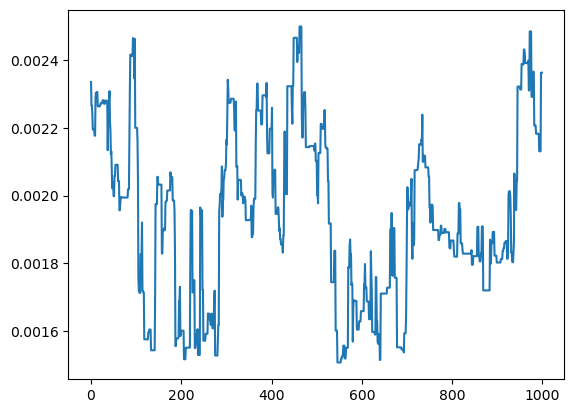

In [28]:
plt.plot(chain[:, 0, 0, 0, 1])